# Multinomial Logistic Regression 

<br>

```{image} images/island_mul_log_reg.png
:class: bg-primary mb-1
:width: 270px
:align: center
```

<br>

Imagine you visting a new island, where you and a team of social scientists are conducting research about the three different religions that are practiced there. Your team is interested in the relationship between the following variables:

 `income` - a continuous numerical variable, indicating the annual income, in 1000s, of each participant

`religion` - a nominal categorical variable, indicating group membership to one of three religions (`Communionism`, `Symmetrianity` or `Lamothianism`)

`biological_sex` - a binary nominal-categorical variable, indicating the the biological sex of each participant

The data from a random sample of islanders is shown below:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from mpl_toolkits.mplot3d import axes3d
import islands_GLM
from scipy.optimize import minimize

# make plots look like R!
islands_GLM.r_ify()

# generate the data for this page
df = islands_GLM.data_gen_multinomial()

# show the data
df

,income,religion,biological_sex
0,78,Lamothianism,female
1,32,Communionism,male
2,55,Communionism,female
3,186,Lamothianism,female
4,0,Communionism,male
...,...,...,...
95,107,Symmetrianity,male
96,29,Symmetrianity,male
97,102,Lamothianism,female
98,22,Symmetrianity,male


As with we've seen with the categorical variables we've dealt with previously, in order to include them in a regression model we need to dummy code them. For the binary categorical variable `biological_sex` we can use 0 and 1 as the dummy codes as previously. However, the variable `religion` has three (rather than two) categories into which observations can fall. It is a *multinomial* rather than binary variable, as it has more than two categories. Resultantly, we will need more than two values in order to dummy code it (we'll use `Communionism = 0`, `Symmetrianity = 1` and `Lamothianism = 2`). The code cell below adds some columns to the dataframe containing the dummy codes:

In [2]:
# generate dummy variables
df['religion_dummy'] =  df['religion'].replace(['Communionism', 'Symmetrianity', 'Lamothianism'], [0, 1, 2])
df['biological_sex_dummy'] =  df['biological_sex'].replace(['female', 'male'], [0, 1])

# show the data
df

,income,religion,biological_sex,religion_dummy,biological_sex_dummy
0,78,Lamothianism,female,2,0
1,32,Communionism,male,0,1
2,55,Communionism,female,0,0
3,186,Lamothianism,female,2,0
4,0,Communionism,male,0,1
...,...,...,...,...,...
95,107,Symmetrianity,male,1,1
96,29,Symmetrianity,male,1,1
97,102,Lamothianism,female,2,0
98,22,Symmetrianity,male,1,1


## Context

We use multinomial logistic regression when we are predicting a categorical variable with several categories, such as `religion`.  As with all generalized linear models, the predictor variables can be of any type (quantitative-continuous, quantitative-discrete, nominal-categorical, ordinal-categorical).

Multinomial logistic regression fits a logistic curve for each outcome category, where each curve shows the predicted probability of an observation falling into that category, given the a set of predictor scores. The image below shows three logistic curves, hypothetically representing the probability of falling into one of three categories, for a given score on a predictor variable:

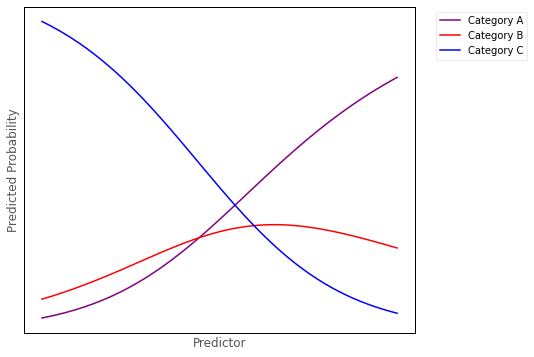

In [3]:
# this code generates the plot below
islands_GLM.multinomial_illustration()

For any value of the predictor we could create a barplot depicting the predicted proportion/probability of scores in each category, for that value of the predictor. Around the middle of the predictor axis on the graph above, such a barplot might look like:

![](images/multi_log_reg_bar.jpg)

This barplot shows a trinomial distribution - it shows the predicted proportion of observations falling into each of the three categories, at a given level of the predictor (a trinomial distribution is a type of multinomial distribution). 

From the conditional distribution perspective, multinomial logistic regression works from by fitting a multinomial distribution for every value of the predictor, as shown in the image below:

![](images/multi_log_reg_conditional.png)

## Model

As we've just seen, when predicting a multinomial outcome variable, we are interested in the probability of observations falling into one of three or more categories, based on the value of the predictor variable(s). We can denote the probability of each observation ($y_i$) falling into category $j$ as:

$ \large \hat{P}_{(y_{i} = j)} = \hat\pi_{ji}$ 

We use one of the categories as a reference category (we do this because probabilities sum to 1, so if we have $c$ categories, we only need to predict probabilities for $c - 1$ categores. We can get the predcited probability for the remaining category by subtracting the other predicted probabilities from 1). The probability of each observation ($y_i$) falling into the reference category can be written as:

$ \large \hat{P}_{(y_{i} = ref)} = \hat\pi_{\text{(r)}i} $

For every category ($j$) apart from the reference category, a separate linear prediction equation predicts the log of the ratio of the probability of falling into that category vs the reference category, for each observation. This is called the log relative risk:

$ \Large \hat{y_{ji}} = ln\left(\frac{Pr(Y=j)}{Pr(Y=\text{Reference})}\right)_{i} = b_{0}^{j} + b_{1}^{j}x_{1i} + ... b_{k}^{j}x_{ki}  $

So, each category apart from the reference category gets its own parameter estimates (intercept and slope(s)). Using the probability symbols from above, we can also write this as:

$ \large \hat{y_{ji}}  = ln \left( \frac{\hat\pi_{j}}{\hat\pi_{\text{(r)}}} \right)_i = b_{0}^{j} + b_{1}^{j}x_{1i} + ... b_{k}^{j}x_{ki}  $

The individual predictions of an observation being in category $j$ ($\hat{y_{j1}}$), for all $n$ observations, using $k$ variables as predictors are:

$$ \large \hat{y_{j1}} = ln \left( \frac{\hat\pi_{j}}{\hat\pi_{\text{(r)}}} \right)_1 = b_{0}^{j} + b_{1}^{j}x_{1i} + ... b_{k}^{j}x_{ki}  $$

$$ \large \hat{y_{j2}}  = ln \left( \frac{\hat\pi_{j}}{\hat\pi_{\text{(r)}}} \right)_2 = b_{0}^{j} + b_{1}^{j}x_{1i} + ... b_{k}^{j}x_{ki}  $$

$$ \large \hat{y_{j3}}  = ln \left( \frac{\hat\pi_{j}}{\hat\pi_{\text{(r)}}} \right)_3 =  b_{0}^{j} + b_{1}^{j}x_{1i} + ... b_{k}^{j}x_{ki} $$

$$ \dots $$

$$ \large \hat{y_{jn}}  = ln \left( \frac{\hat\pi_{j}}{\hat\pi_{\text{(r)}}} \right)_n =  b_{0}^{j} + b_{1}^{j}x_{1i} + ... b_{k}^{j}x_{ki}  $$

Where:

$\hat{y_{ji}} $ : is the predicted log relative risk of falling into category $j$ for a given set of predictor scores, for the $i$th observation

$b_0$ : is the intercept term, the predicted value of the outcome variable when all predictors equal 0

$b_1$ : is the slope of the 1st predictor variable

$x_{1i}$ : is the score on the the first predictor variable, for the $i$th observation

$b_k$ : is the slope of the $k$th predictor variable

$x_{ki}$ : is the score on the $k$th predictor variable, for the $i$th observation

In matrix form, the model for each of the $j$ non-reference categories is:

$$
\Large \begin{bmatrix}
           {\hat{y_{j1}} } \\
           {\hat{y_{j2}} } \\
           {\hat{y_{j3}} } \\
           \vdots \\
           {\hat{y_{jn}} }
         \end{bmatrix} = \begin{bmatrix}
           {ln \left( \frac{\hat\pi_{j}}{\hat\pi_{\text{(r)}}} \right)_1 } \\
           {ln \left( \frac{\hat\pi_{j}}{\hat\pi_{\text{(r)}}} \right)_2 } \\
           {ln \left( \frac{\hat\pi_{j}}{\hat\pi_{\text{(r)}}} \right)_3 }  \\
           \vdots \\
           {\ln \left( \frac{\hat\pi_{j}}{\hat\pi_{\text{(r)}}} \right)_n}
         \end{bmatrix} = \begin{bmatrix}
           {1} & {x_{11}} & \dots & {x_{k1}}\\ 
           {1} & {x_{12}} & \dots & {x_{k2}}\\ 
           {1} & {x_{13}} & \dots & {x_{k3}}\\ 
           \vdots & \vdots & \vdots & \vdots\\
           {1} & {x_{1n}} & \dots & {x_{kn}} \\ 
         \end{bmatrix} \begin{bmatrix}
           {b^{j}_{0}} \\ 
           \vdots \\
           {b^{j}_{k}} \\ 
         \end{bmatrix} 
$$


## Parameter Estimation


The predicted probability of falling into class $j$ for observation $i$ is given by:

$ \large \hat\pi_{ji} = \frac{e^{\hat{y_{ji}}}}{1 + e^{\hat{y_{1}}} + ... e^{\hat{y_{ji}}}}  = \frac{e^{\hat{y_{ji}}}}{1 + \sum{e^{\hat{y_{ji}}}}} $

And predicted probability of falling into reference category is given by:

$ \large \hat\pi_{\text{(r)}i} = \frac{1}{1 + \sum{e^{\hat{y_{ji}}}}} = 1 - \sum \hat\pi_{ji} $

As with binary logisitc regression, we us a set of indicator variables for each of the $j$ categories:

$\text{indicator}_{0} = \begin{cases}
  \text{0 if observation is NOT in outcome category 0}\\ 
  \text{1 if observation is in outcome category 0}   
\end{cases}$

$\text{indicator}_{1} = \begin{cases}
  \text{0 if observation is NOT in outcome category 1}\\ 
  \text{1 if observation is in outcome category 1}   
\end{cases}$

$$ \dots $$

$\text{indicator}_{j} = \begin{cases}
  \text{0 if observation is NOT in outcome category j}\\ 
  \text{1 if observation is in outcome category j}   
\end{cases}$

If an observation has a 0 for all the $j$ indicator variables, it is in the reference category.

The model gets its parameters, by maximizing the likelilhood function:

$ \large \prod\limits_{i = 1}^{n} \hat\pi_{0i}^{\text{indicator}_{0i}} \hat\pi_{1i}^{\text{indicator}_{1i}} ...\hat\pi_{ji}^{\text{indicator}_{ji}} $

In practice, the parameter estimates are obtained by minimizing the negative log-likelihood function (much easier for a computer to work with!):

$ \large - \sum\limits_{i = 1}^{n} \text{indicator}_{ji} * \large[ \hat{y_{ji}}  - \ln(1 + \sum{e^{\hat{y_{ji}}}} )\large]$

## Implementation

Returning to the data from the island, your team want to fit a multinomial logistic regression model, predicting `religion` from `income`:

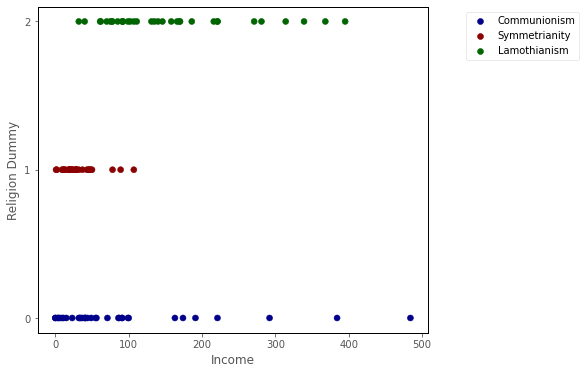

In [4]:
# this code generates the plot below
islands_GLM.relig_scatter(df)

The python code below defines a function which implements the negative log-likelihood formula from above:

In [5]:
# the cost function for multinomial logistic regression
def mnlogit_cost(intercept_and_slope, x, y):

    intercept_1, slope_1, intercept_2, slope_2, = intercept_and_slope
    
    predicted_log_rel_risk_1 = intercept_1 + slope_1 * x
    predicted_log_rel_risk_2 = intercept_2 + slope_2 * x

    y_dummies = pd.get_dummies(y)
     
    log_likelihood = np.sum(y_dummies[1].values * predicted_log_rel_risk_1 + y_dummies[2].values * predicted_log_rel_risk_2 - np.log(1 + np.exp(predicted_log_rel_risk_1) +  np.exp(predicted_log_rel_risk_2)))

    return -log_likelihood

The python cell below tests the the negative log likelihood function with the parameters: 

$b^{j}_0$ = 0.1

$b^{j}_1$ = 0.1

for the `religion ~ income` data:

In [6]:
# testing the cost function with intercept = .1, slope = .1, for each linear prediction equation
mnlogit_cost([.1,.1,.1,.1], df['income'], df['religion_dummy'])

383.65330980255266

The cell below implements code which passes the negative log-likelihood function and some intitial guesses at the parameters, to the [minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) function, from the [SciPy](https://scipy.org/) library.

`mimimize` will try various sets of parameters until it finds the parameters which give the lowest value of the function:

In [7]:
# finding the paramters which give the minimum value of the cost function
minimize(mnlogit_cost, [1,1,1,1], args =(df['income'], df['religion_dummy']), tol = 1e-16).x

array([ 1.3580911 , -0.02791203, -0.78305941,  0.00661693])

We can see that these are the same parameter estimates obtained by fitting a multinomial logistic regression using the `statsmodels` library (the `statsmodels` parameter estimates are in the `coef` section of the regression table shown below):

In [8]:
# fit a multinomial logistic regression using statsmodels
mod = smf.mnlogit('religion_dummy ~ income', data = df).fit()

# show the regression table
mod.summary()

Optimization terminated successfully.
         Current function value: 0.892573
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:         religion_dummy   No. Observations:                  100
Model:                        MNLogit   Df Residuals:                       96
Method:                           MLE   Df Model:                            2
Date:                Fri, 01 Jul 2022   Pseudo R-squ.:                  0.1872
Time:                        19:59:56   Log-Likelihood:                -89.257
converged:                       True   LL-Null:                       -109.82
Covariance Type:            nonrobust   LLR p-value:                 1.173e-09
====================================================================================
religion_dummy=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.3581      0.439      3.096      0.002       0.498       2.218
income              -0.0279      0.008     -3.417      0.001      -0.044      -0.012
------------------------------------------------------------------------------------
religion_dummy=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.7831      0.402     -1.950      0.051      -1.570       0.004
income               0.0066      0.003      2.362      0.018       0.001       0.012
====================================================================================
"""

The graph below shows the predicted probabilities of falling into each category, as a function of income, using the predicted probabilities from the multinomial logisitc regression model we just fit:

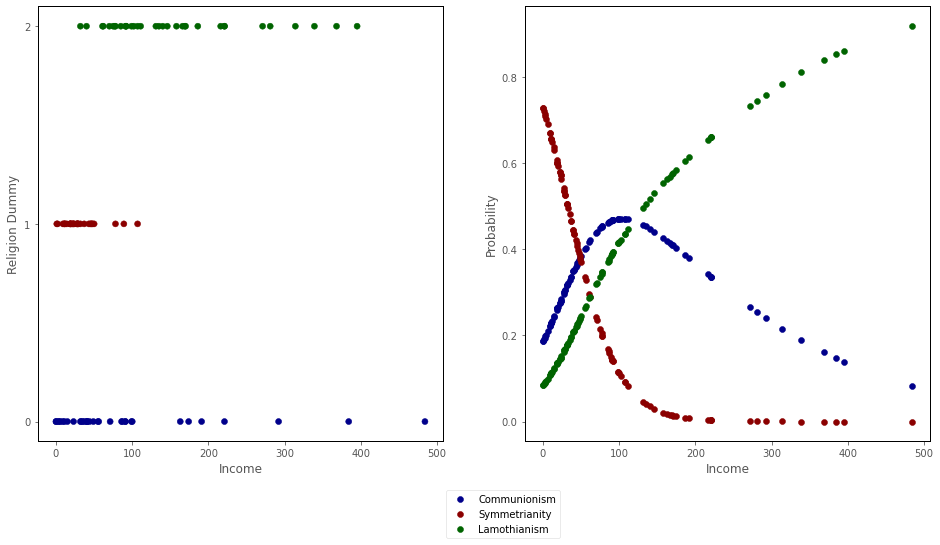

In [9]:
# this code generates the plot below
islands_GLM.scatter_prob_subplots(mod, df)

## Interpretation (one predictor model)

Note: the intercept and slope are shown under the `coef` heading in the regression table above, the associated $p$-values are shown under `P>|z|`.

The coefficients tell us:

$b^{j}_0$ : the intercept, the expected value of the log relative risk of being in category $j$ for an observation where the predictor equals 0.

$b^{j}_1$: the predicted change in the  the log relative risk of being in category $j$, for a 1-unit increase in the predictor.

Each prediction from the model comes to us on the scale of the log relative risk. So for the $i$th observation, the predicted relative risk of falling into category $j$ is:

$ \large \hat{y_{ji}} = ln \left( \frac{\hat\pi_{j}}{\hat\pi_{\text{(r)}}} \right)_i = b_{0}^{j} + b_{1}^{j}x_{1i} + ... b_{k}^{j}x_{ki}  $

To get the predicted probabilities, for the $j$ categories, we use the conversion formula:

$ \large \hat\pi_{ji} = \frac{e^{\hat{y_{ji}}}}{1 + e^{\hat{y_{1}}} + ... e^{\hat{y_{ji}}}}  = \frac{e^{\hat{y_{ji}}}}{1 + \sum{e^{\hat{y_{ji}}}}} $

And for the predicted probability og the $i$th observation falling into the reference category:

$ \large \hat\pi_{\text{(r)}i} = \frac{1}{1 + \sum{e^{\hat{y_{ji}}}}} = 1 - \sum \hat\pi_{ji} $

## Multinomial Logistic Regression with multiple predictors

In more than two dimensions - e.g. with more than one predictor - the multinomial logistic regression model fits several probability surfaces, one for each outcome cateogory, which show the predicted probability of category membership, given the predictor variables. (In higher dimensions, a manifold is fit).

The graph below shows a multinomial logisitc regression model fit to an outcome with three cateogries, as a function of two continuous predictor variables. Each surface represents the probability of being in the associate category, for any pairing of predictor scores:

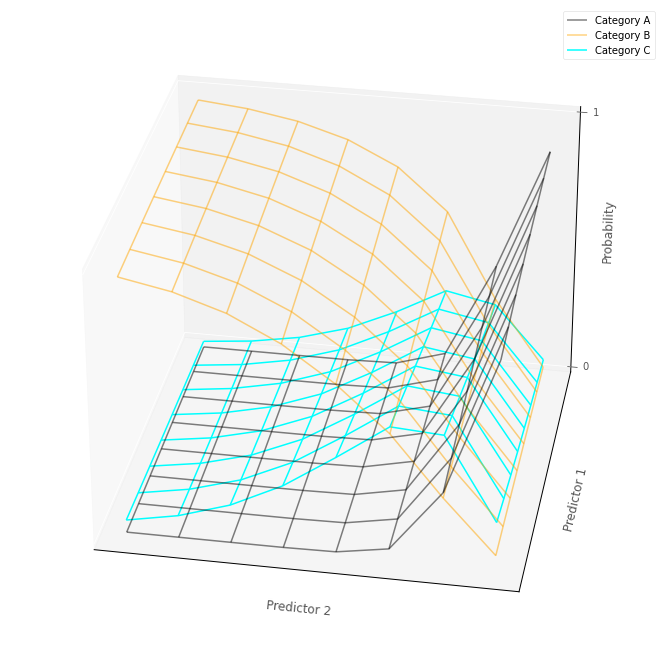

In [10]:
# show how multinomial logistic regression works in multiple dimensions
islands_GLM.three_D_model_plot_multinomial('income', 'biological_sex_dummy', 
                   'religion_dummy', 2.5185199239560534, -0.030011667415127917, -1.0302006835581514, -0.5366928830869722, 0.008857262577209785, -0.7421731046952662,
                  df, legend_loc = (1,1), wireframe_only = True, azim = 100)

Remember that the data collected on this island contained the following variables:

`income`: a continuous numerical variable, indicating the annual income, in 1000s, of each participant

`religion`: a nominal categorical variable, indicating group membership to one of three religions: `Communionism`, `Symmetrianity` or `Lamothianism`

`biological_sex`: a binary nominal-categorical variable, indicating the the biological sex of each participant

We'll now fit a multinomial logisitc regression model predicting `religion` from `income` and `biological_sex`. The model is `religion ~ income + biological_sex`.

The dataframe is shown again below, it already contains a dummy variable for `biological_sex`:

In [11]:
# show the dataframe
df

,income,religion,biological_sex,religion_dummy,biological_sex_dummy
0,78,Lamothianism,female,2,0
1,32,Communionism,male,0,1
2,55,Communionism,female,0,0
3,186,Lamothianism,female,2,0
4,0,Communionism,male,0,1
...,...,...,...,...,...
95,107,Symmetrianity,male,1,1
96,29,Symmetrianity,male,1,1
97,102,Lamothianism,female,2,0
98,22,Symmetrianity,male,1,1


We'll use the `statsmodels` library to fit the new model `religion ~ income + biological_sex`:

In [12]:
# fit a multinomial logistic regression model using statsmodels
mod = smf.mnlogit('religion_dummy ~ income + biological_sex_dummy', data = df).fit()

# show the regression table
mod.summary()

Optimization terminated successfully.
         Current function value: 0.856044
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:         religion_dummy   No. Observations:                  100
Model:                        MNLogit   Df Residuals:                       94
Method:                           MLE   Df Model:                            4
Date:                Fri, 01 Jul 2022   Pseudo R-squ.:                  0.2205
Time:                        19:59:56   Log-Likelihood:                -85.604
converged:                       True   LL-Null:                       -109.82
Covariance Type:            nonrobust   LLR p-value:                 7.666e-10
========================================================================================
    religion_dummy=1       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.2239      0.631      0.355      0.723      -1.012       1.460
income                  -0.0228      0.008     -2.809      0.005      -0.039      -0.007
biological_sex_dummy     1.3944      0.613      2.275      0.023       0.193       2.596
----------------------------------------------------------------------------------------
    religion_dummy=2       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.6714      0.457     -1.469      0.142      -1.567       0.224
income                   0.0065      0.003      2.317      0.021       0.001       0.012
biological_sex_dummy    -0.2678      0.533     -0.502      0.616      -1.313       0.778
========================================================================================
"""

As with the other generalized linear models with have seen with two predictors, we can show the model in 3D dataspace. The graph below, on the left hand plot, shows the probability surfaces for each outcome category, derived from the model. The plot on the right shows the raw data:

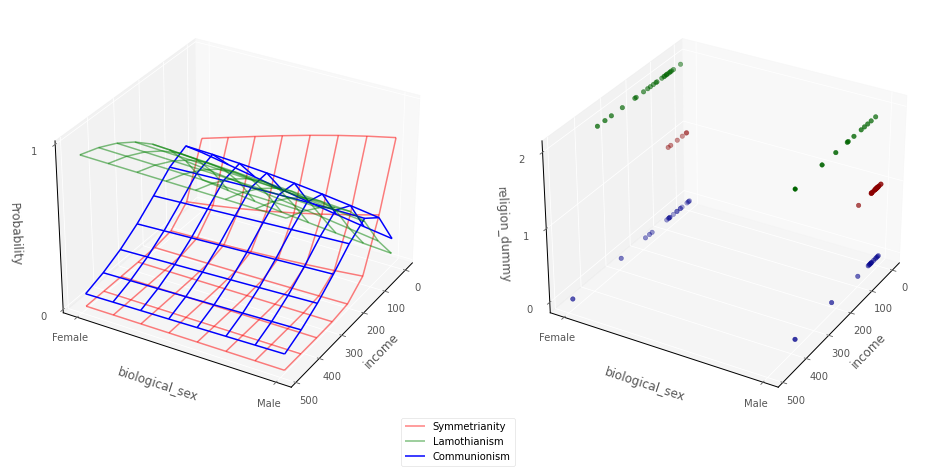

In [13]:
# this code generates the plot below
intercept_1, income_slope_1, biological_sex_dummy_slope_1 = mod.params[0][:]
intercept_2, income_slope_2, biological_sex_dummy_slope_2 = mod.params[1][:]
islands_GLM.three_D_model_plot_multinomial('income', 'biological_sex_dummy', 
                   'religion_dummy', intercept_1, income_slope_1, biological_sex_dummy_slope_1, intercept_2, income_slope_2, biological_sex_dummy_slope_2,
                  df)

## Interpretation (multiple predictors)

Note: the intercept and slopes are shown under the `coef` heading in the regression table above, the associated $p$-values are shown under `P>|z|`.

The intercept, for a given category, tells us the predicted log relative risk of being in that category, for an observation whose score on all other predictors was 0. The $p$-value for the intercept tells us how (un)likely it would be to obtain an intercpet of the value we obtained, if randomly sampling from a population where the true intercept was 0.

The slope, for a given category, of each predictor tells us the predicted difference in log relative risk of being in that category between scores for two hypothetical observations which differed *only* by a one unit score in that predictor, controlling for the other variables in the model. The $p$-values for each predictor tell us how (un)likely it would be, under repeated random sampling, to observe a slope of the size we observed if the population slope was zero.

## Statistical interaction in Multinomial Logistic Regression

The definition of statistical interaction is: the influence of a predictor on the outcome variable depends on the value of some other predictor(s).

If we fit an interaction term in a multinomial logistic regression model, then this allows each logistic regression probability surfaces to 'bend', so that the effect of the predictors is not constant, but depends on the value of the other predictors. The graph below shows this for one logisitc probability surface:

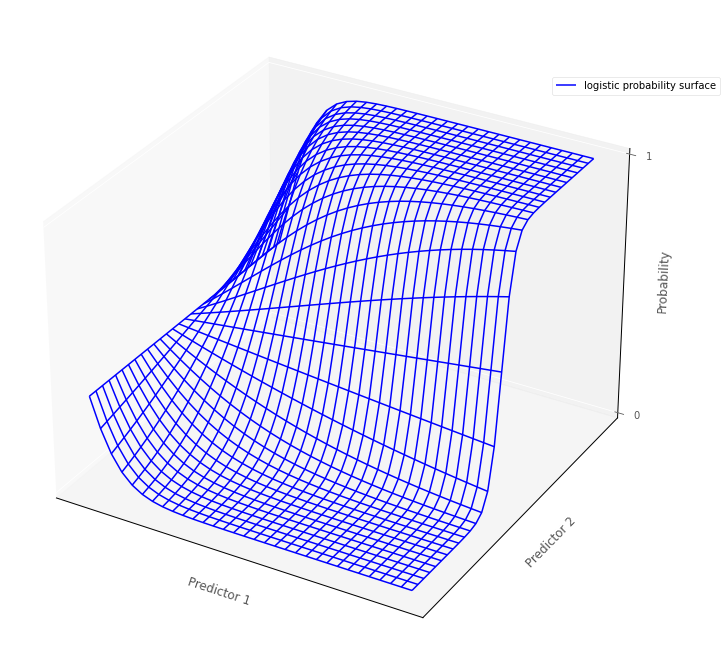

In [14]:
# this code generates the plot below
islands_GLM.three_D_logistic_plot(interaction = True)

That's it for multinomial logistic regression (for now). You can visit another page/island via the links in the table of contents, and at the bottom of this page...

***
By [pxr687](99_about_the_author.ipynb) 